# Multi-class Classification: 7 Skin Disease Types

This notebook performs complete multi-class classification pipeline:
1. **Preprocess Data** - Load and prepare images with 7 disease labels
2. **Train Model** - Build and train SVM multi-class classifier
3. **Evaluate Model** - Assess performance with comprehensive metrics

**Classes (7):**
- akiec: Actinic keratoses
- bcc: Basal cell carcinoma
- bkl: Benign keratosis-like lesions
- df: Dermatofibroma
- mel: Melanoma
- nv: Melanocytic nevi
- vasc: Vascular lesions

---

## Step 1: Preprocess Data

In [1]:
# Import libraries
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report
)
from image_loader import (
    load_images_from_metadata, verify_image_metadata_match,
    get_image_path, load_and_preprocess_image
)
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load metadata
metadata_path = '../data/HAM10000_metadata.csv'
df = pd.read_csv(metadata_path)

print(f"Metadata loaded: {df.shape[0]} samples")
print(f"\nColumns: {df.columns.tolist()}")

# Diagnosis mapping
dx_dict = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions'
}

print(f"\nDiagnosis distribution:")
for dx, count in df['dx'].value_counts().items():
    print(f"  {dx} ({dx_dict[dx]}): {count} ({count/len(df)*100:.1f}%)")

Metadata loaded: 10015 samples

Columns: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']

Diagnosis distribution:
  nv (Melanocytic nevi): 6705 (66.9%)
  mel (Melanoma): 1113 (11.1%)
  bkl (Benign keratosis-like lesions): 1099 (11.0%)
  bcc (Basal cell carcinoma): 514 (5.1%)
  akiec (Actinic keratoses): 327 (3.3%)
  vasc (Vascular lesions): 142 (1.4%)
  df (Dermatofibroma): 115 (1.1%)


In [3]:
# Load images (this may take a few minutes)
print("Loading images... This may take several minutes.")
print("=" * 60)

IMAGE_SIZE = (224, 224)
images, loaded_image_ids = load_images_from_metadata(
    df,
    base_path='../data',
    target_size=IMAGE_SIZE,
    normalize=True,
    verbose=True
)

print(f"\nLoaded images shape: {images.shape}")
print(f"Value range: [{images.min():.3f}, {images.max():.3f}]")
print(f"Memory usage: {images.nbytes / (1024**3):.2f} GB")

Loading images... This may take several minutes.
Loaded 1000/10015 images...
Loaded 2000/10015 images...
Loaded 3000/10015 images...
Loaded 4000/10015 images...
Loaded 5000/10015 images...
Loaded 6000/10015 images...
Loaded 7000/10015 images...
Loaded 8000/10015 images...
Loaded 9000/10015 images...
Loaded 10000/10015 images...

Successfully loaded: 10015/10015 images

Loaded images shape: (10015, 224, 224, 3)
Value range: [0.000, 1.000]
Memory usage: 5.62 GB


In [4]:
# Filter metadata and encode labels
df_filtered = df[df['image_id'].isin(loaded_image_ids)].reset_index(drop=True)

# Encode diagnosis for multi-class classification
le_diagnosis = LabelEncoder()
y_multiclass = le_diagnosis.fit_transform(df_filtered['dx'])

print(f"Metadata filtered: {len(df_filtered)} samples")
print(f"\nNumber of classes: {len(le_diagnosis.classes_)}")
print(f"Classes: {le_diagnosis.classes_}")

Metadata filtered: 10015 samples

Number of classes: 7
Classes: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    images,
    y_multiclass,
    test_size=0.2,
    random_state=42,
    stratify=y_multiclass
)

print("Train-Test Split:")
print(f"Training: {X_train.shape}")
print(f"Testing: {X_test.shape}")

print(f"\nTraining class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    class_name = le_diagnosis.classes_[label]
    print(f"  {label}: {class_name} - {count} ({count/len(y_train)*100:.1f}%)")

Train-Test Split:
Training: (8012, 224, 224, 3)
Testing: (2003, 224, 224, 3)

Training class distribution:
  0: akiec - 262 (3.3%)
  1: bcc - 411 (5.1%)
  2: bkl - 879 (11.0%)
  3: df - 92 (1.1%)
  4: mel - 890 (11.1%)
  5: nv - 5364 (66.9%)
  6: vasc - 114 (1.4%)


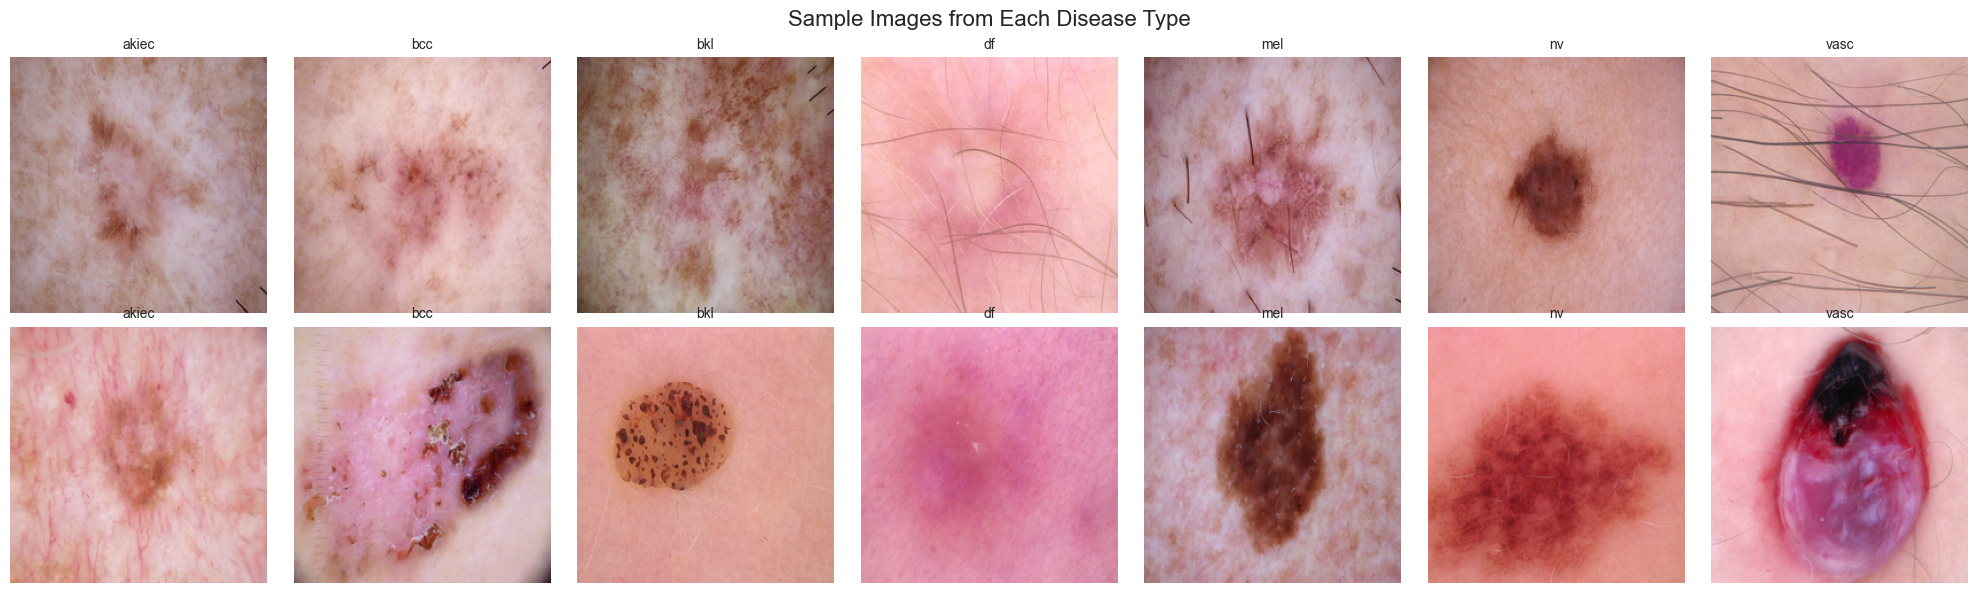

Data preprocessing complete!


In [6]:
# Visualize samples from each class
fig, axes = plt.subplots(2, 7, figsize=(20, 6))
fig.suptitle('Sample Images from Each Disease Type', fontsize=16)

for idx, dx_code in enumerate(le_diagnosis.classes_):
    # Find indices for this diagnosis in training set
    class_indices = np.where(y_train == idx)[0]
    
    if len(class_indices) >= 2:
        # Show 2 samples
        for row in range(2):
            sample_idx = class_indices[row]
            axes[row, idx].imshow(X_train[sample_idx])
            axes[row, idx].set_title(f"{dx_code}", fontsize=10)
            axes[row, idx].axis('off')

plt.tight_layout()
plt.show()

print("Data preprocessing complete!")

## Step 2: Train Model

In [7]:
# Flatten images for SVM
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Flattened training data: {X_train_flat.shape}")
print(f"Flattened testing data: {X_test_flat.shape}")

Flattened training data: (8012, 150528)
Flattened testing data: (2003, 150528)


In [8]:
# Initialize SVM model for multi-class
svm_multiclass = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42,
    probability=True,
    class_weight='balanced',
    decision_function_shape='ovr'  # One-vs-Rest
)

print("SVM Multi-class Model Configuration:")
print(f"  Kernel: {svm_multiclass.kernel}")
print(f"  C: {svm_multiclass.C}")
print(f"  Gamma: {svm_multiclass.gamma}")
print(f"  Class Weight: {svm_multiclass.class_weight}")
print(f"  Decision Function: {svm_multiclass.decision_function_shape}")
print(f"  Number of Classes: {len(le_diagnosis.classes_)}")

SVM Multi-class Model Configuration:
  Kernel: rbf
  C: 1.0
  Gamma: scale
  Class Weight: balanced
  Decision Function: ovr
  Number of Classes: 7


In [9]:
# Train the model
import time

print("Training multi-class SVM model...")
print("This may take a few minutes...")
start_time = time.time()

svm_multiclass.fit(X_train_flat, y_train)

training_time = time.time() - start_time

print(f"Training complete! Time: {training_time:.2f} seconds")
print(f"Total support vectors: {sum(svm_multiclass.n_support_)}")
print(f"Support vectors per class: {dict(zip(range(len(le_diagnosis.classes_)), svm_multiclass.n_support_))}")

Training multi-class SVM model...
This may take a few minutes...
Training complete! Time: 18060.29 seconds
Total support vectors: 6262
Support vectors per class: {0: np.int32(257), 1: np.int32(388), 2: np.int32(823), 3: np.int32(92), 4: np.int32(813), 5: np.int32(3779), 6: np.int32(110)}


In [10]:
# Make predictions
y_train_pred = svm_multiclass.predict(X_train_flat)
y_test_pred = svm_multiclass.predict(X_test_flat)
y_test_proba = svm_multiclass.predict_proba(X_test_flat)

print("Predictions complete!")
print(f"\nSample predictions (first 10):")
for i in range(min(10, len(y_test))):
    true_class = le_diagnosis.classes_[y_test[i]]
    pred_class = le_diagnosis.classes_[y_test_pred[i]]
    match = "✓" if y_test[i] == y_test_pred[i] else "✗"
    print(f"  {match} True: {true_class:6s} | Predicted: {pred_class:6s}")

Predictions complete!

Sample predictions (first 10):
  ✗ True: nv     | Predicted: bcc   
  ✗ True: nv     | Predicted: mel   
  ✓ True: mel    | Predicted: mel   
  ✗ True: nv     | Predicted: mel   
  ✗ True: bkl    | Predicted: mel   
  ✓ True: nv     | Predicted: nv    
  ✓ True: mel    | Predicted: mel   
  ✗ True: nv     | Predicted: mel   
  ✓ True: nv     | Predicted: nv    
  ✓ True: nv     | Predicted: nv    


## Step 3: Evaluate Model

In [11]:
# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("=" * 50)
print("ACCURACY SCORES")
print("=" * 50)
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Testing Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

accuracy_diff = train_accuracy - test_accuracy
if accuracy_diff > 0.05:
    print(f"\nWarning: Possible overfitting (diff: {accuracy_diff:.4f})")
else:
    print(f"\nModel generalizes well (diff: {accuracy_diff:.4f})")

random_accuracy = 1.0 / len(le_diagnosis.classes_)
print(f"\nRandom guessing: {random_accuracy:.4f} ({random_accuracy*100:.2f}%)")
print(f"Improvement over random: {(test_accuracy - random_accuracy)*100:.2f}%")

ACCURACY SCORES
Training Accuracy: 0.6653 (66.53%)
Testing Accuracy:  0.5831 (58.31%)


Random guessing: 0.1429 (14.29%)
Improvement over random: 44.03%


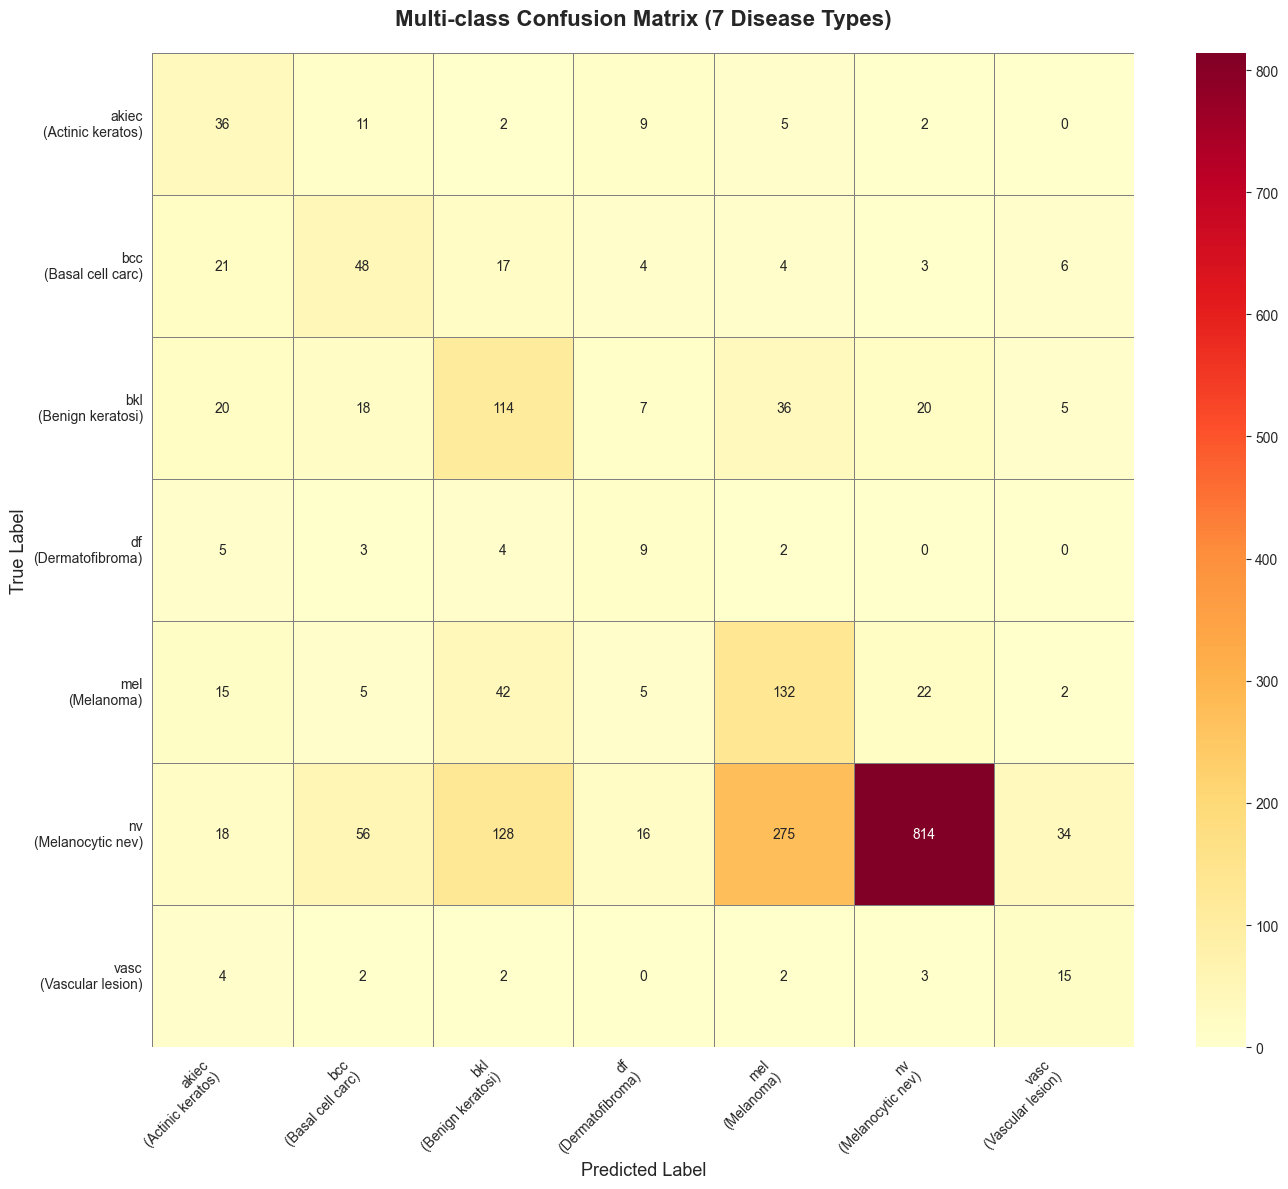

Confusion matrix saved!


In [12]:
# Confusion matrix
os.makedirs('../results', exist_ok=True)

cm_test = confusion_matrix(y_test, y_test_pred)
class_names = le_diagnosis.classes_

plt.figure(figsize=(14, 12))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='YlOrRd', cbar=True,
            xticklabels=[f"{cls}\n({dx_dict[cls][:15]})" for cls in class_names],
            yticklabels=[f"{cls}\n({dx_dict[cls][:15]})" for cls in class_names],
            linewidths=0.5, linecolor='gray')
plt.title('Multi-class Confusion Matrix (7 Disease Types)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=13)
plt.xlabel('Predicted Label', fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../results/multiclass_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix saved!")

In [13]:
# Per-class analysis
print("=" * 60)
print("PER-CLASS ACCURACY")
print("=" * 60)

for i, class_name in enumerate(class_names):
    total_actual = cm_test[i, :].sum()
    correct = cm_test[i, i]
    class_accuracy = correct / total_actual if total_actual > 0 else 0
    
    print(f"\n{class_name} ({dx_dict[class_name]}):")
    print(f"  Total samples: {total_actual}")
    print(f"  Correctly classified: {correct}")
    print(f"  Class accuracy: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")
    
    # Most confused with
    if total_actual > 0:
        misclassified = cm_test[i, :].copy()
        misclassified[i] = 0
        if misclassified.max() > 0:
            most_confused_idx = misclassified.argmax()
            most_confused_count = misclassified[most_confused_idx]
            print(f"  Most confused with: {class_names[most_confused_idx]} ({most_confused_count} times)")

PER-CLASS ACCURACY

akiec (Actinic keratoses):
  Total samples: 65
  Correctly classified: 36
  Class accuracy: 0.5538 (55.38%)
  Most confused with: bcc (11 times)

bcc (Basal cell carcinoma):
  Total samples: 103
  Correctly classified: 48
  Class accuracy: 0.4660 (46.60%)
  Most confused with: akiec (21 times)

bkl (Benign keratosis-like lesions):
  Total samples: 220
  Correctly classified: 114
  Class accuracy: 0.5182 (51.82%)
  Most confused with: mel (36 times)

df (Dermatofibroma):
  Total samples: 23
  Correctly classified: 9
  Class accuracy: 0.3913 (39.13%)
  Most confused with: akiec (5 times)

mel (Melanoma):
  Total samples: 223
  Correctly classified: 132
  Class accuracy: 0.5919 (59.19%)
  Most confused with: bkl (42 times)

nv (Melanocytic nevi):
  Total samples: 1341
  Correctly classified: 814
  Class accuracy: 0.6070 (60.70%)
  Most confused with: mel (275 times)

vasc (Vascular lesions):
  Total samples: 28
  Correctly classified: 15
  Class accuracy: 0.5357 (53.57

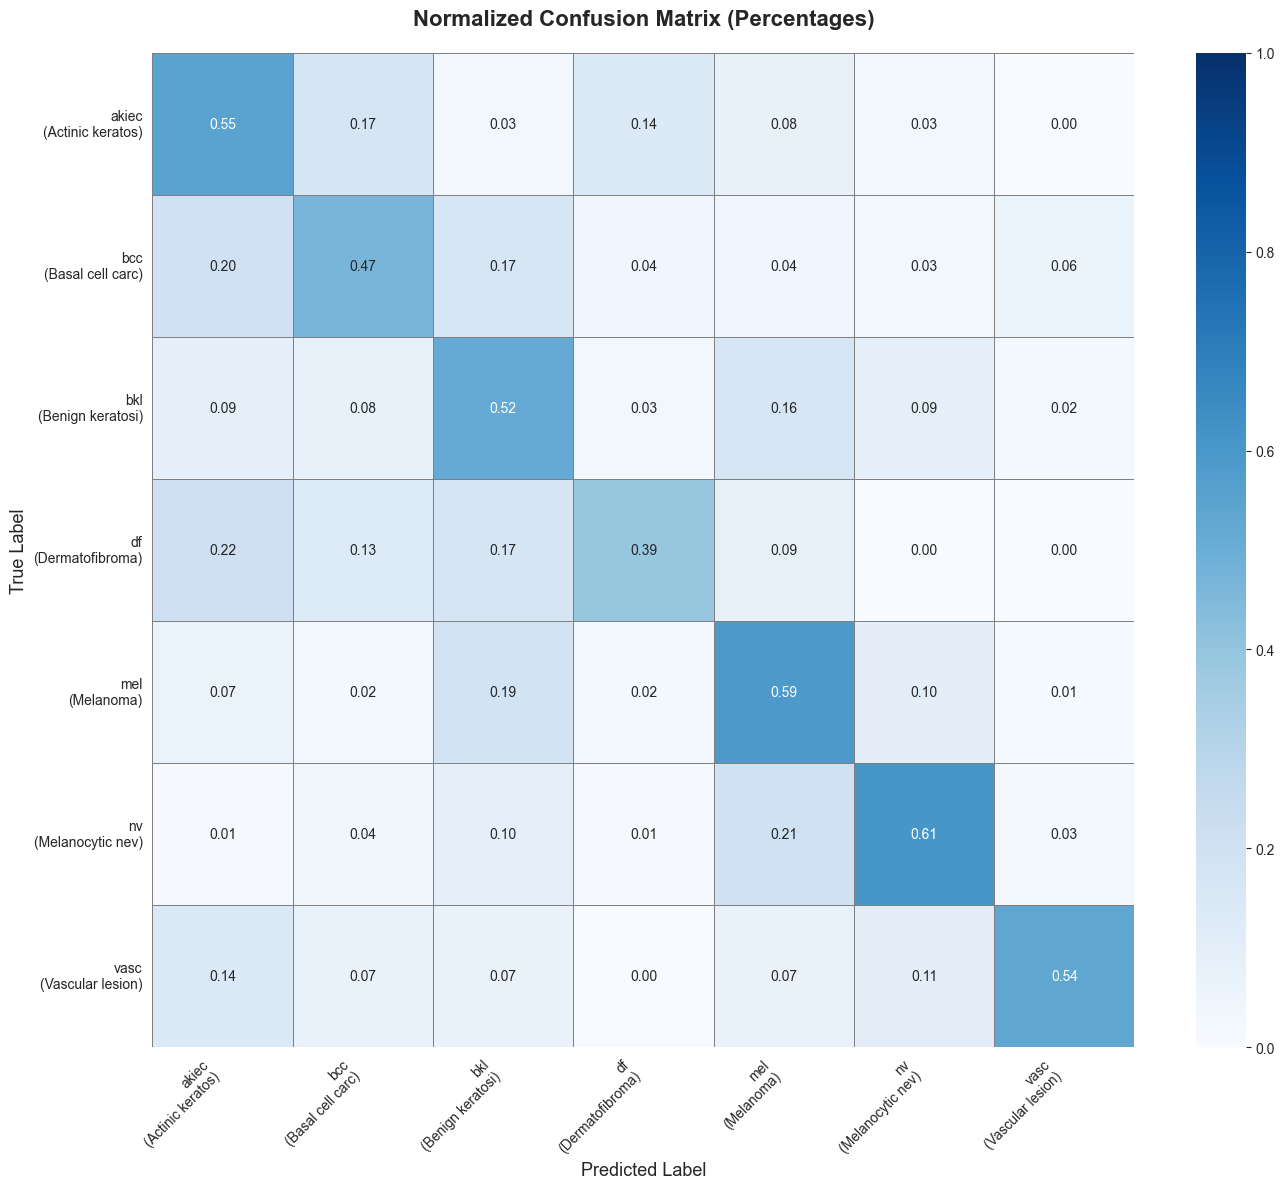

Normalized confusion matrix saved!


In [14]:
# Normalized confusion matrix
cm_normalized = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            xticklabels=[f"{cls}\n({dx_dict[cls][:15]})" for cls in class_names],
            yticklabels=[f"{cls}\n({dx_dict[cls][:15]})" for cls in class_names],
            linewidths=0.5, linecolor='gray', vmin=0, vmax=1)
plt.title('Normalized Confusion Matrix (Percentages)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=13)
plt.xlabel('Predicted Label', fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../results/multiclass_confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

print("Normalized confusion matrix saved!")

In [15]:
# Classification report
print("=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)

report = classification_report(
    y_test,
    y_test_pred,
    target_names=[f"{cls} ({dx_dict[cls]})" for cls in class_names],
    digits=4
)
print(report)

# Get report as dictionary
report_dict = classification_report(
    y_test,
    y_test_pred,
    target_names=[f"{cls}" for cls in class_names],
    output_dict=True,
    zero_division=0
)

# Save to CSV
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv('../results/multiclass_classification_report.csv')
print("\nClassification report saved to CSV!")

CLASSIFICATION REPORT
                                     precision    recall  f1-score   support

          akiec (Actinic keratoses)     0.3025    0.5538    0.3913        65
         bcc (Basal cell carcinoma)     0.3357    0.4660    0.3902       103
bkl (Benign keratosis-like lesions)     0.3689    0.5182    0.4310       220
                df (Dermatofibroma)     0.1800    0.3913    0.2466        23
                     mel (Melanoma)     0.2895    0.5919    0.3888       223
              nv (Melanocytic nevi)     0.9421    0.6070    0.7383      1341
            vasc (Vascular lesions)     0.2419    0.5357    0.3333        28

                           accuracy                         0.5831      2003
                          macro avg     0.3801    0.5234    0.4171      2003
                       weighted avg     0.7360    0.5831    0.6252      2003


Classification report saved to CSV!


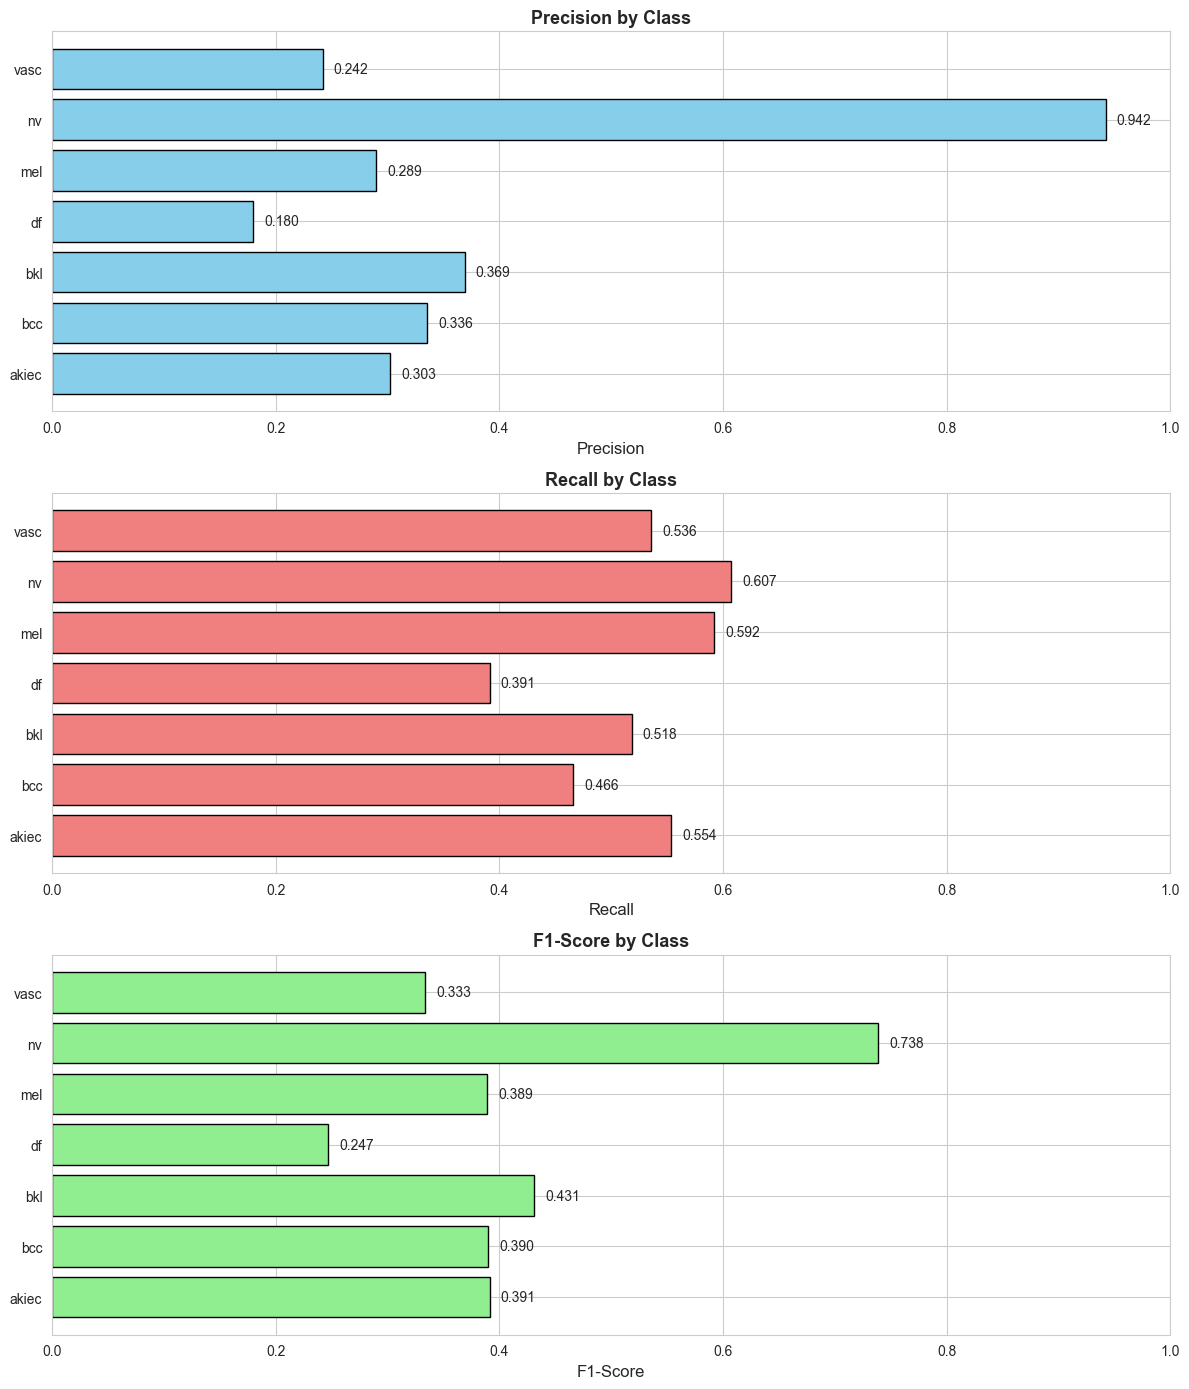

Per-class metrics visualization saved!


In [16]:
# Visualize per-class metrics
classes = [f"{cls}" for cls in class_names]
precision_scores = [report_dict[cls]['precision'] for cls in classes]
recall_scores = [report_dict[cls]['recall'] for cls in classes]
f1_scores = [report_dict[cls]['f1-score'] for cls in classes]

fig, axes = plt.subplots(3, 1, figsize=(12, 14))

# Precision
axes[0].barh(classes, precision_scores, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Precision', fontsize=12)
axes[0].set_title('Precision by Class', fontsize=13, fontweight='bold')
axes[0].set_xlim([0, 1])
for i, v in enumerate(precision_scores):
    axes[0].text(v + 0.01, i, f'{v:.3f}', va='center')

# Recall
axes[1].barh(classes, recall_scores, color='lightcoral', edgecolor='black')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_title('Recall by Class', fontsize=13, fontweight='bold')
axes[1].set_xlim([0, 1])
for i, v in enumerate(recall_scores):
    axes[1].text(v + 0.01, i, f'{v:.3f}', va='center')

# F1-Score
axes[2].barh(classes, f1_scores, color='lightgreen', edgecolor='black')
axes[2].set_xlabel('F1-Score', fontsize=12)
axes[2].set_title('F1-Score by Class', fontsize=13, fontweight='bold')
axes[2].set_xlim([0, 1])
for i, v in enumerate(f1_scores):
    axes[2].text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.savefig('../results/multiclass_metrics_by_class.png', dpi=300, bbox_inches='tight')
plt.show()

print("Per-class metrics visualization saved!")

In [17]:
# Top-2 Accuracy
top2_correct = 0
for i in range(len(y_test)):
    top2_pred = y_test_proba[i].argsort()[-2:][::-1]
    if y_test[i] in top2_pred:
        top2_correct += 1

top2_accuracy = top2_correct / len(y_test)

print("=" * 60)
print("TOP-K ACCURACY")
print("=" * 60)
print(f"Top-1 Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Top-2 Accuracy: {top2_accuracy:.4f} ({top2_accuracy*100:.2f}%)")
print(f"\nInterpretation:")
print(f"  {test_accuracy*100:.1f}% of predictions are exactly correct")
print(f"  {top2_accuracy*100:.1f}% have true class in top 2 predictions")

TOP-K ACCURACY
Top-1 Accuracy: 0.5831 (58.31%)
Top-2 Accuracy: 0.8697 (86.97%)

Interpretation:
  58.3% of predictions are exactly correct
  87.0% have true class in top 2 predictions


In [18]:
# Save model
os.makedirs('../models', exist_ok=True)

with open('../models/svm_multiclass_model.pkl', 'wb') as f:
    pickle.dump(svm_multiclass, f)

metrics = {
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'confusion_matrix': cm_test,
    'classification_report': report_dict,
    'top2_accuracy': top2_accuracy,
    'training_time': training_time,
    'class_names': class_names.tolist(),
    'dx_dict': dx_dict
}

with open('../models/svm_multiclass_metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)

# Save label encoder
with open('../models/label_encoder_multiclass.pkl', 'wb') as f:
    pickle.dump(le_diagnosis, f)

print("Model, metrics, and label encoder saved successfully!")

Model, metrics, and label encoder saved successfully!


In [19]:
# Final Summary
print("=" * 70)
print("MULTI-CLASS CLASSIFICATION - FINAL SUMMARY")
print("=" * 70)
print(f"\nModel: Support Vector Machine (SVM) - Multi-class")
print(f"Number of Classes: {len(class_names)}")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Total Support Vectors: {sum(svm_multiclass.n_support_)}")

print(f"\nPerformance Metrics:")
print(f"  Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  Testing Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Top-2 Accuracy:    {top2_accuracy:.4f} ({top2_accuracy*100:.2f}%)")
print(f"  Random Baseline:   {random_accuracy:.4f} ({random_accuracy*100:.2f}%)")

print(f"\nBest Performing Classes:")
class_f1_scores = [(cls, report_dict[cls]['f1-score']) for cls in classes]
class_f1_scores_sorted = sorted(class_f1_scores, key=lambda x: x[1], reverse=True)
for i, (cls, f1) in enumerate(class_f1_scores_sorted[:3], 1):
    print(f"  {i}. {cls} ({dx_dict[cls][:30]}): F1 = {f1:.4f}")

print(f"\nWorst Performing Classes:")
for i, (cls, f1) in enumerate(class_f1_scores_sorted[-3:], 1):
    print(f"  {i}. {cls} ({dx_dict[cls][:30]}): F1 = {f1:.4f}")

print(f"\nSaved Artifacts:")
print(f"  - Model: ../models/svm_multiclass_model.pkl")
print(f"  - Metrics: ../models/svm_multiclass_metrics.pkl")
print(f"  - Label Encoder: ../models/label_encoder_multiclass.pkl")
print(f"  - Confusion Matrix: ../results/multiclass_confusion_matrix.png")
print(f"  - Normalized CM: ../results/multiclass_confusion_matrix_normalized.png")
print(f"  - Metrics by Class: ../results/multiclass_metrics_by_class.png")
print(f"  - Report CSV: ../results/multiclass_classification_report.csv")

print("\n" + "=" * 70)
print("MULTI-CLASS CLASSIFICATION COMPLETE!")
print("=" * 70)

MULTI-CLASS CLASSIFICATION - FINAL SUMMARY

Model: Support Vector Machine (SVM) - Multi-class
Number of Classes: 7
Training Time: 18060.29 seconds
Total Support Vectors: 6262

Performance Metrics:
  Training Accuracy: 0.6653 (66.53%)
  Testing Accuracy:  0.5831 (58.31%)
  Top-2 Accuracy:    0.8697 (86.97%)
  Random Baseline:   0.1429 (14.29%)

Best Performing Classes:
  1. nv (Melanocytic nevi): F1 = 0.7383
  2. bkl (Benign keratosis-like lesions): F1 = 0.4310
  3. akiec (Actinic keratoses): F1 = 0.3913

Worst Performing Classes:
  1. mel (Melanoma): F1 = 0.3888
  2. vasc (Vascular lesions): F1 = 0.3333
  3. df (Dermatofibroma): F1 = 0.2466

Saved Artifacts:
  - Model: ../models/svm_multiclass_model.pkl
  - Metrics: ../models/svm_multiclass_metrics.pkl
  - Label Encoder: ../models/label_encoder_multiclass.pkl
  - Confusion Matrix: ../results/multiclass_confusion_matrix.png
  - Normalized CM: ../results/multiclass_confusion_matrix_normalized.png
  - Metrics by Class: ../results/multicla